# Прогноз типа личности

### Введение

В этой записной книжке описаны шаги, которые предприняns для решения задачи EDSA Kaggle «Предсказание профиля личности MBTI».

Согласно описанию задачи, от нас требовалось построить и обучить модель/модели, способные использовать НЛП (обработку естественного языка) для прогнозирования метки MBTI человека, используя только то, что они публикуют на онлайн-форумах.

Условно, каждый тип личности состоит из четырех бинарных переменных:

- Психика: интроверт (И) или экстраверт (Э)
- Природа: формалист (Ф) или любознательный (Л)
- Сознание: небрежный (Н) или пунктуальный (П)
- Нейротизм: уравновешенный (У) или тревожный (Т)

У каждого человека будет только одна из двух категорий для каждой переменной. Объединение четырех переменных дает окончательный тип личности. Например, человек с экстравертным, любознательным, пунктуальным и уравновешенным характером получит тип личности "ЭЛПУ".

Решение должно быть способно предсказывать метки с наименьшей ошибкой для каждой из четырех переменных, т. е. предсказывать четыре отдельные метки для каждого человека, которые при объединении приводят к типу личности этого человека.

#### 1. Предварительная обработка данных

Разведывательный анализ данных (EDA)  
Очистка текста  
Векторизация и латентный семантический анализ  
Построение целевых векторов  

#### 2. Тестирование модели

Построение и сравнение базовых моделей  
Настройка параметров  
Стекирование моделей  
Сравнение настроенной производительности  

#### 3. Прогнозирование

Оформление документов для подачи  
Полученные результаты  
Выводы  

### 1. Предварительная обработка данных

In [1]:
# модули для работы с табличными данными
import numpy as np
import pandas as pd

# модули для получения графиков
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# модули для работы с текстом
import re
import string

# специальные NLP модули
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
# Следующий код пропускает предупреждения Python из выходных данных
import warnings
warnings.filterwarnings("ignore")

Из домашнего каталога импортируем два набора данных, обучаем и тестируем.

In [3]:
#df = pd.read_csv('train.csv')
df = pd.read_csv('../input/polycode-2022/train.csv')
#test = pd.read_csv("../input/test.csv")

### Разведывательный анализ данных (EDA)

In [4]:
df.head(4)

,id,текст,интроверсия/экстраверсия,формализм/любознательность,небрежность/пунктуальность,уравновешенность/тревожность
0,1,Начнем сначала. На картине изображено 2 лица: ...,35,44,38,65
1,2,"Здорово, дружище! Давно не виделись. У меня вс...",35,44,38,65
2,3,"Привет, Данил! Как дела? Я надеюсь, что все х...",39,41,47,41
3,4,На картине двое: бабушка и внук. Молодость и с...,39,41,47,41


In [5]:
df['психика'] = df['интроверсия/экстраверсия'].apply(lambda x: 'И' if x<50 else 'Э')
df['природа'] = df['формализм/любознательность'].apply(lambda x: 'Ф' if x<50 else 'Л')
df['сознание'] = df['небрежность/пунктуальность'].apply(lambda x: 'Н' if x<50 else 'П')
df['нейротизм'] = df['уравновешенность/тревожность'].apply(lambda x: 'У' if x<50 else 'Т')

In [6]:
df['тип'] = df['психика']+df['природа']+df['сознание']+df['нейротизм']

In [7]:
df['тип'].value_counts()

ЭЛПТ    89
ЭЛПУ    77
ИЛПУ    35
ИЛПТ    30
ЭФПТ    22
ЭЛНТ    22
ИФНТ    20
ЭЛНУ    18
ИФПТ    16
ЭФНТ    13
ИФНУ    12
ЭФПУ    12
ИФПУ    11
ЭФНУ    10
ИЛНТ    10
ИЛНУ     3
Name: тип, dtype: int64

На следующем графике показано распределение классов.

<AxesSubplot:xlabel='тип', ylabel='count'>

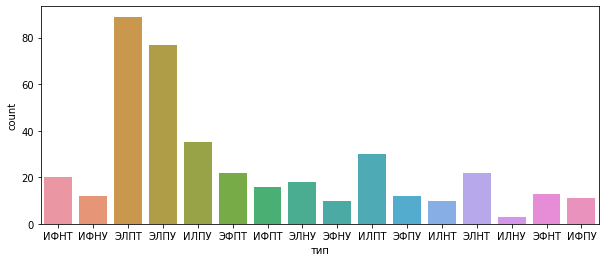

In [8]:
plt.figure(figsize=(10,4))
sns.countplot(x="тип", data=df)

Помня о том, что каждый из 16 типов личности состоит из четырех черт, для которых есть два возможных значения, на следующем графике с кодовыми ячейками представлены круговые диаграммы, которые показывают соотношение между двумя вариантами для каждой из четырех черт.


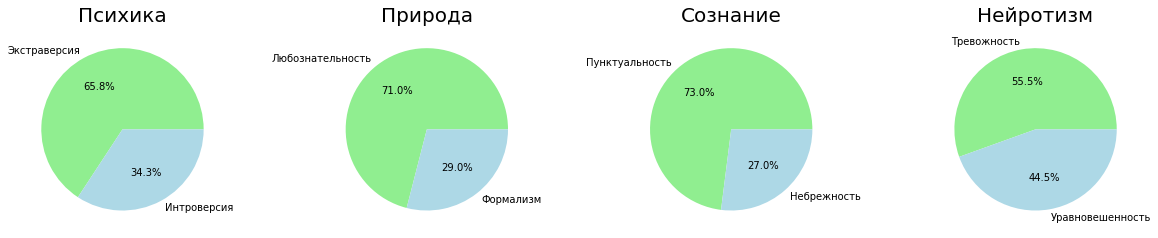

In [9]:
type1 = df['тип'].apply(lambda x: 'Интроверсия' if x[0] == 'И' else 'Экстраверсия')
type2 = df['тип'].apply(lambda x: 'Формализм' if x[1] == 'Ф' else 'Любознательность')
type3 = df['тип'].apply(lambda x: 'Небрежность' if x[2] == 'Н' else 'Пунктуальность')
type4 = df['тип'].apply(lambda x: 'Уравновешенность' if x[3] == 'У' else 'Тревожность')

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace = 0.5)
ax1 = plt.subplot(1, 4, 1)
plt.pie(type1.value_counts(), labels = type1.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax1.set_title('Психика', fontsize=20)

ax2 = plt.subplot(1, 4, 2)
plt.pie(type2.value_counts(), labels = type2.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax2.set_title('Природа', fontsize=20)

ax3 = plt.subplot(1, 4, 3)
plt.pie(type3.value_counts(), labels = type3.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax3.set_title('Сознание', fontsize=20)

ax4 = plt.subplot(1, 4, 4)
plt.pie(type4.value_counts(), labels = type4.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax4.set_title('Нейротизм', fontsize=20)
plt.show()

В следующем примере кода показано, как реализовать передискретизацию:

In [10]:
df['психика'] = df['психика'].apply(lambda x: 0 if x == 'И' else 1)
df['природа'] = df['природа'].apply(lambda x: 0 if x == 'Ф' else 1)
df['сознание'] = df['сознание'].apply(lambda x: 0 if x == 'Н' else 1)
df['нейротизм'] = df['нейротизм'].apply(lambda x: 0 if x == 'У' else 1)

In [11]:
df

,id,текст,интроверсия/экстраверсия,формализм/любознательность,небрежность/пунктуальность,уравновешенность/тревожность,психика,природа,сознание,нейротизм,тип
0,1,Начнем сначала. На картине изображено 2 лица: ...,35,44,38,65,0,0,0,1,ИФНТ
1,2,"Здорово, дружище! Давно не виделись. У меня вс...",35,44,38,65,0,0,0,1,ИФНТ
2,3,"Привет, Данил! Как дела? Я надеюсь, что все х...",39,41,47,41,0,0,0,0,ИФНУ
3,4,На картине двое: бабушка и внук. Молодость и с...,39,41,47,41,0,0,0,0,ИФНУ
4,5,"Привет, Маш! Как давно я не писала тебе! Все с...",58,70,58,51,1,1,1,1,ЭЛПТ
...,...,...,...,...,...,...,...,...,...,...,...
395,396,"Сначала я куплю себе большой дом за городом, м...",44,45,46,40,0,0,0,0,ИФНУ
396,397,На картине я вижу мужчину-пахаря. Он со своим ...,58,48,61,59,1,0,1,1,ЭФПТ
397,398,Я не буду спешить с покупками. Я постараюсь вс...,58,48,61,59,1,0,1,1,ЭФПТ
398,399,На картине изображена деревня. Женщина справа ...,39,53,55,38,0,1,1,0,ИЛПУ


In [12]:
from sklearn.utils import resample

d = {}
new_train = pd.DataFrame()
class_list = df['тип'].value_counts().index
avg_class_size = int(np.average(df['тип'].value_counts()))

for mbti_type in class_list:
    d[mbti_type] = df[df['тип'] == mbti_type]
    d[mbti_type] = resample(d[mbti_type], replace = True, n_samples = avg_class_size)
    new_train = pd.concat([new_train, d[mbti_type]])

Следующие две ячейки кода определяют и вызывают функцию, которая создает диаграммы облака слов для каждого из 16 типов личности.

In [13]:
def generate_wordcloud(text, title):
    '''
    Create and generate a word cloud image
    
    Parameters:
        text (str): The text string with all words
        title (str): The title of the word cloud
    '''
    
    wordcloud = WordCloud(background_color="white").generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize = 15)

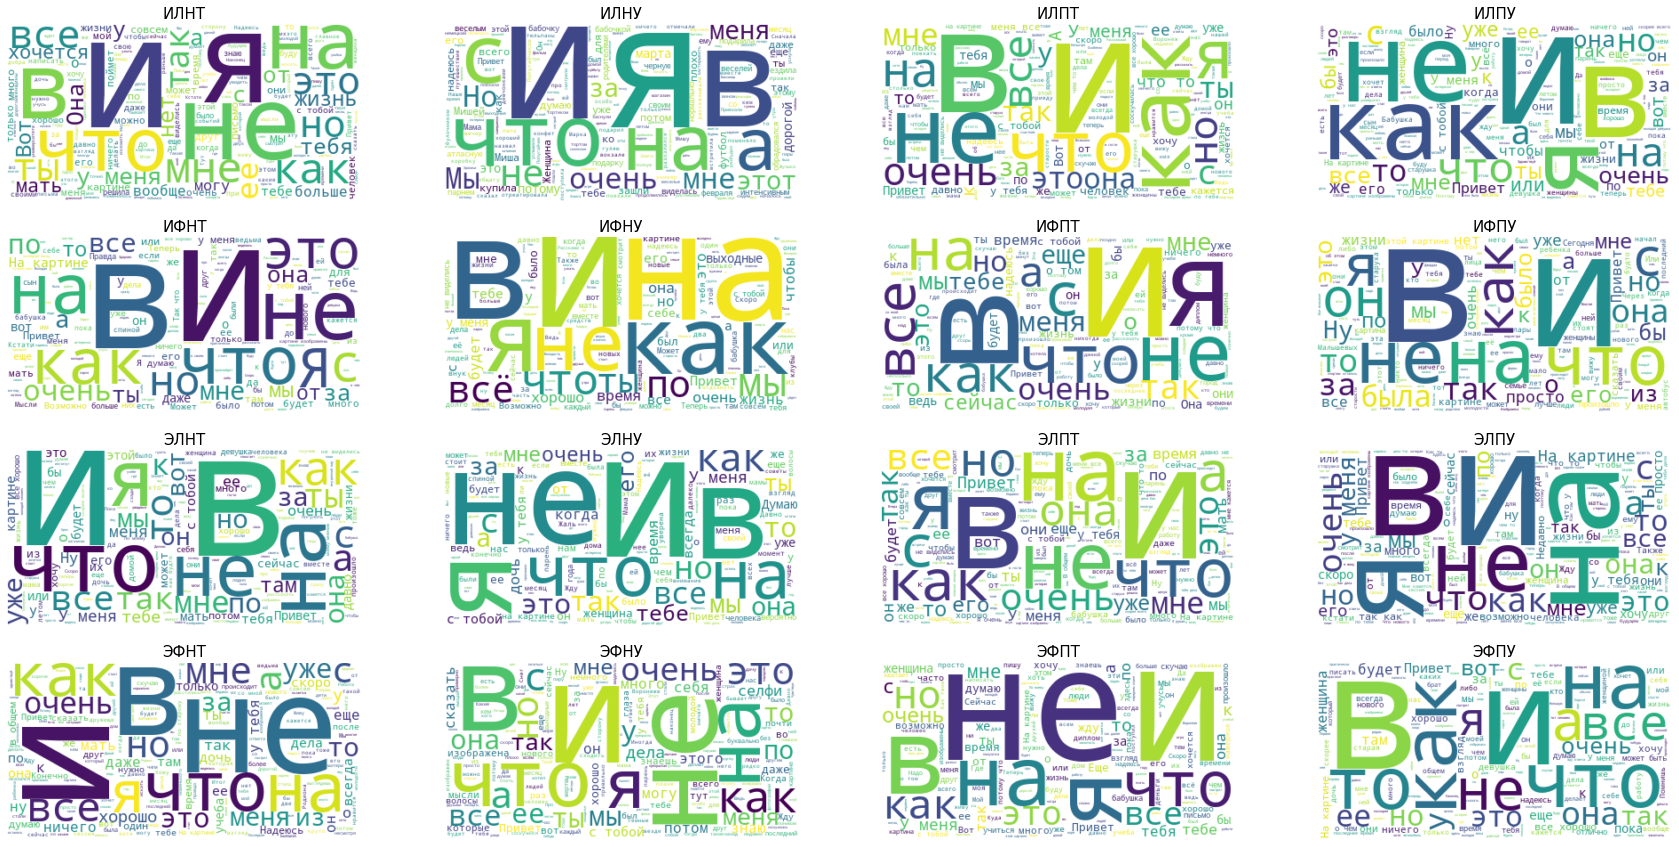

In [14]:
train_by_personality = df.groupby("тип")['текст'].apply(' '.join).reset_index()

plt.figure(figsize=(30,15))
for i, t in enumerate(train_by_personality['тип']):
    text = train_by_personality.iloc[i,1]
    ax = plt.subplot(4, 4, i+1)
    generate_wordcloud(text, t)
plt.show()

От "облака слов" можно увидеть следующее наблюденее: необходимо избавиться от стоп-слов.

## Чистка текста

In [15]:
def clean_text(text):
    text = text.lower()
    text = text.replace('\%','')
    text = re.sub('\[.*?!\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+-!—', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = " ".join(filter(lambda x:x[0]!="@", text.split()))
    return text

#Apply the function

In [16]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))

#add words that aren't in the NLTK stopwords list
new_stopwords = ['очень', 'так', 'это', 'как', 'в', 'я', 'то', 'что', 'ТО', 'ЧТО', 'тo', 'чтo', 'ТO', 'ЧТO', 'то что', 'чтото', 'чемто']

stop_words.update(new_stopwords)
final_stop_words = set(stop_words)

print(stop_words)

{'раз', 'между', 'них', 'при', 'иногда', 'была', 'будет', 'тем', 'в', 'ТO', 'ну', 'нее', 'быть', 'конечно', 'какая', 'а', 'зачем', 'об', 'три', 'ней', 'ничего', 'про', 'о', 'ему', 'наконец', 'чуть', 'того', 'том', 'на', 'ж', 'всегда', 'меня', 'все', 'никогда', 'чемто', 'ЧТО', 'ЧТO', 'из', 'больше', 'моя', 'потом', 'с', 'для', 'потому', 'совсем', 'лучше', 'они', 'другой', 'до', 'там', 'у', 'и', 'разве', 'ты', 'кто', 'вот', 'после', 'то что', 'вас', 'тут', 'чтоб', 'был', 'ним', 'вы', 'эти', 'себя', 'во', 'ни', 'вам', 'перед', 'он', 'когда', 'хоть', 'ТО', 'нас', 'тоже', 'над', 'один', 'же', 'да', 'что', 'не', 'так', 'всю', 'этот', 'мой', 'она', 'нибудь', 'если', 'есть', 'сам', 'где', 'сейчас', 'всех', 'я', 'чтобы', 'ее', 'нет', 'этой', 'теперь', 'этом', 'нельзя', 'опять', 'тот', 'надо', 'всего', 'но', 'только', 'эту', 'как', 'тo', 'за', 'мы', 'более', 'чтото', 'чего', 'почти', 'даже', 'куда', 'то', 'здесь', 'по', 'это', 'еще', 'вдруг', 'чем', 'будто', 'много', 'были', 'через', 'или', 'мне

In [17]:
df['очищенный текст'] = df['текст'].apply(lambda x: clean_text(x))
df['очищенный текст'] = df['очищенный текст'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

In [18]:
df

,id,текст,интроверсия/экстраверсия,формализм/любознательность,небрежность/пунктуальность,уравновешенность/тревожность,психика,природа,сознание,нейротизм,тип,очищенный текст
0,1,Начнем сначала. На картине изображено 2 лица: ...,35,44,38,65,0,0,0,1,ИФНТ,начнем сначала картине изображено лица молодое...
1,2,"Здорово, дружище! Давно не виделись. У меня вс...",35,44,38,65,0,0,0,1,ИФНТ,здорово дружище давно виделись нормально продо...
2,3,"Привет, Данил! Как дела? Я надеюсь, что все х...",39,41,47,41,0,0,0,0,ИФНУ,привет данил дела надеюсь последний месяц напр...
3,4,На картине двое: бабушка и внук. Молодость и с...,39,41,47,41,0,0,0,0,ИФНУ,картине двое бабушка внук молодость старость б...
4,5,"Привет, Маш! Как давно я не писала тебе! Все с...",58,70,58,51,1,1,1,1,ЭЛПТ,привет маш давно писала тебе свободное время з...
...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,"Сначала я куплю себе большой дом за городом, м...",44,45,46,40,0,0,0,0,ИФНУ,сначала куплю большой дом городом машину возмо...
396,397,На картине я вижу мужчину-пахаря. Он со своим ...,58,48,61,59,1,0,1,1,ЭФПТ,картине вижу мужчинупахаря своим конем пашет з...
397,398,Я не буду спешить с покупками. Я постараюсь вс...,58,48,61,59,1,0,1,1,ЭФПТ,буду спешить покупками постараюсь медленно обд...
398,399,На картине изображена деревня. Женщина справа ...,39,53,55,38,0,1,1,0,ИЛПУ,картине изображена деревня женщина справа — ма...


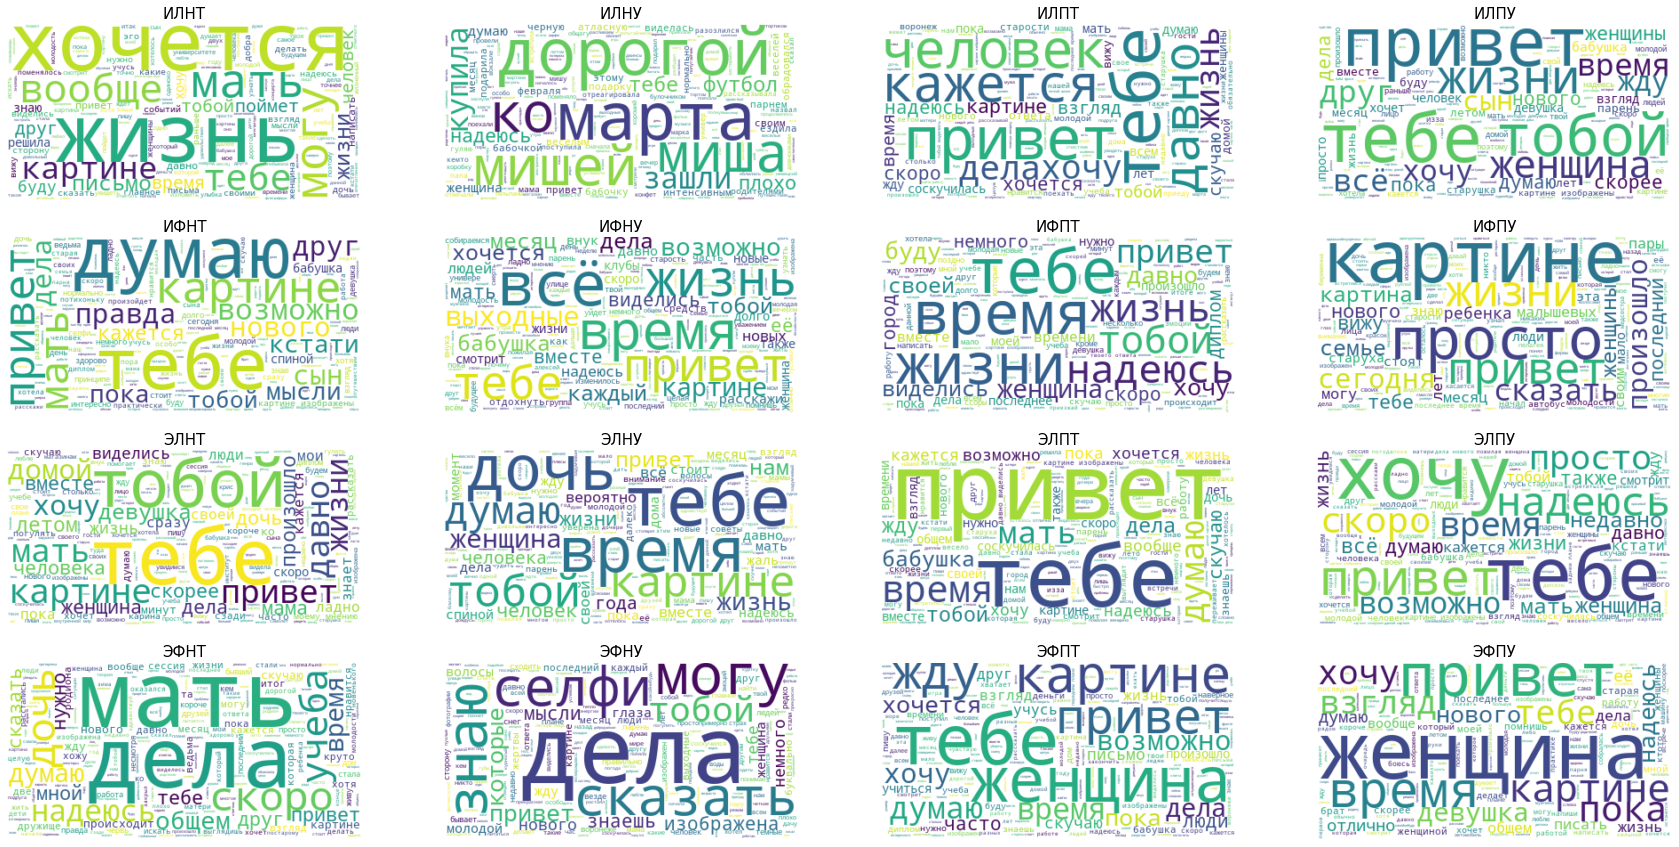

In [19]:
train_by_personality = df.groupby("тип")['очищенный текст'].apply(' '.join).reset_index()

plt.figure(figsize=(30,15))
for i, t in enumerate(train_by_personality['тип']):
    text = train_by_personality.iloc[i,1]
    ax = plt.subplot(4, 4, i+1)
    generate_wordcloud(text, t)
plt.show()

### Векторизация и латентный семантический анализ

Векторизация данных будет проведена частотно-инверсным векторизатором частоты документа, выходом которого является матрица признаков TF-IDF.

Частота термина: обобщает, как часто данное слово появляется в тексте.  
Обратная частота документа: уменьшает количество слов, которые часто встречаются в тексте.

In [20]:
#max_length = 1000
#max_fatures = 2000
#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
#tokenizer.fit_on_texts(df['очищенный текст'].values)
#df_X = tokenizer.texts_to_sequences(df['очищенный текст'].values)
#df_X = pad_sequences(X, maxlen=max_length, truncating='pre', padding='pre')
vectorizer = TfidfVectorizer()
df_X = vectorizer.fit_transform(df['очищенный текст'])

Чтобы преодолеть проблему высокой размерности в нашей входной матрице, был выполнен латентный семантический анализ (LSA), метод уменьшения размерности, на матрице TF-IDF с использованием разложения по сингулярным значениям (SVD).

Согласно документации sklearn.decomposition.TruncatedSVD, при выполнении LSA рекомендуется n_components = 100.

In [21]:
svd = TruncatedSVD(n_components = 100)
df_X = svd.fit_transform(df_X)

Затем мы разделяем данные на X, обучающий набор и тест.

In [22]:
X = df_X[:200,:]
test = df_X[200:,:]

#### Построение целевых векторов
Взяв четыре двоичные переменные, составляющие целевой «тип», были построены следующие цели:

- Психика = 0 для интроверта и 1 для экстраверта  
- Природа = 0 для формалиста и 1 для любознательного    
- Сознание = 0 для небрежного и 1 для пунктульного  
- Нейротизм = 0 для уравновешенного и 1 для тревожного  

In [23]:
X

array([[ 0.13637081,  0.17465828,  0.12968388, ...,  0.07707601,
         0.02829647, -0.03073096],
       [ 0.09169217, -0.04001685, -0.00411803, ..., -0.01256383,
         0.21854804,  0.08929864],
       [ 0.1537585 , -0.10914728,  0.00416395, ...,  0.08200105,
         0.05340217,  0.00265078],
       ...,
       [ 0.26106173, -0.17536785, -0.01341026, ..., -0.00611868,
        -0.03173946, -0.01083791],
       [ 0.12193403,  0.13213845,  0.03867827, ..., -0.0356605 ,
        -0.03385577,  0.0904525 ],
       [ 0.13946682, -0.0940255 ,  0.0053393 , ...,  0.0298317 ,
         0.0258815 , -0.05224844]])

In [24]:
y = df['тип'][:200]

y_mind = y.apply(lambda x: 0 if x[0] == 'И' else 1)
y_nature = y.apply(lambda x: 0 if x[1] == 'Ф' else 1)
y_consciousness = y.apply(lambda x: 0 if x[2] == 'Н' else 1)
y_neuroticism = y.apply(lambda x: 0 if x[3] == 'У' else 1)

In [25]:
len(X)

200

In [26]:
df_train = df[['id', 'текст', 'психика', 'природа', 'сознание', 'нейротизм']]
df_test = pd.read_csv('../input/polycode-2022/test.csv')

sample_submission = pd.read_csv('../input/polycode-2022/random_example.csv')

# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['train'] = 1 # помечаем где у нас трейн
df_test['train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

In [27]:
df['очищенный текст'] = df['текст'].apply(lambda x: clean_text(x))
df['очищенный текст'] = df['очищенный текст'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [28]:
vectorizer = TfidfVectorizer()
df_X = vectorizer.fit_transform(df['очищенный текст'])

In [29]:
svd = TruncatedSVD(n_components = 100)
df_X = svd.fit_transform(df_X)

In [30]:
X = df_X[:400,:]
test = df_X[400:,:]

In [31]:
y = df[:400]

y_mind = y['психика']
y_nature = y['природа']
y_consciousness = y['сознание']
y_neuroticism = y['нейротизм']

## Тестирование моделей


In [32]:
# Modules for model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier

# Modules for model evaluation and parameter tuning
from sklearn.model_selection import  cross_val_score, GridSearchCV

In [33]:
LogR_model = LogisticRegression()
RFC_model = RandomForestClassifier()
SVC_model = SVC(probability = True)
XGB_model = XGBClassifier()

category = [(y_mind, "психика"), (y_nature, "природа"), (y_consciousness, "сознание"), (y_neuroticism, "нейротизм")]
models = [(LogR_model, "LOG"), (RFC_model, "RFC"), (SVC_model, 'SVC'), (XGB_model, 'XGB')]

Чтобы сравнить производительность каждой из четырех базовых моделей, был запущен следующий цикл, результаты которого приведены в таблице ниже.

In [34]:
for a in category:
    print("-----", a[1], "-----")
    for b in models:
        score = -1*round(np.average(cross_val_score(b[0], X, a[0], cv = 4, scoring = 'neg_log_loss', n_jobs = 4)),5)
        print(b[1], ": ", score)

----- психика -----
LOG :  0.64109
RFC :  0.65213
SVC :  0.6477
XGB :  1.01692
----- природа -----
LOG :  0.59891
RFC :  0.61457
SVC :  0.59714
XGB :  0.88162
----- сознание -----
LOG :  0.59276
RFC :  0.6075
SVC :  0.58307
XGB :  0.95527
----- нейротизм -----
LOG :  0.6935
RFC :  0.71254
SVC :  0.70308
XGB :  1.0389


В таблице показаны значения Log Loss для каждой пары модель-целевая категория. Обратите внимание, что в среднем логистическая регрессия превосходит другие, в то время как XGB имеет самую низкую производительность, поэтому лучше исключить эту модель из дальнейшего рассмотрения.

## Делаем прогноз

Создание документов для проверки

В ячейке кода ниже мы определяем функцию, которая соответствует модели, прогнозирует классификацию типа личности для матрицы тренировочных данных и сохраняет файл отправки в домашнем каталоге.

In [35]:
def submission_file(model, file_name):
    '''
    Saves to the home directory a submission file by making MBTI classificatio predictions for the test matrix using the input model.

    Parameters:
        model (sklearn model): The model used to make to make predictions
        file_name (str): The name of the file to be used.
    
    Returns:
        The function does not return an object but rather saves to the home directory a submission file.
    '''

    model.fit(X,y_mind)
    prediction_mind = pd.DataFrame(model.predict(test))
    prediction_mind.columns = ['психика']

    model.fit(X,y_nature)
    prediction_nature = pd.DataFrame(model.predict(test))
    prediction_nature.columns = ['природа']

    model.fit(X,y_consciousness)
    prediction_consciousness = pd.DataFrame(model.predict(test))
    prediction_consciousness.columns = ['сознание']

    model.fit(X,y_neuroticism)
    prediction_neuroticism = pd.DataFrame(model.predict(test))
    prediction_neuroticism.columns = ['нейротизм']
    
    submission = prediction_mind.join([prediction_nature, prediction_consciousness, prediction_neuroticism])
    submission.reset_index(inplace=True)
    submission['id'] = submission['index'] + 13501
    submission.drop('index', axis = 1, inplace = True)
    submission_df = submission[['id','психика', 'природа', 'сознание', 'нейротизм']]
    
    submission_df.to_csv(file_name, index = False)

In [36]:
test

array([[ 0.26950549, -0.09205303, -0.1425329 , ..., -0.01560709,
        -0.00088369, -0.01463139],
       [ 0.21528033, -0.05133389, -0.10754172, ...,  0.07995082,
        -0.03652578, -0.05652151],
       [ 0.24626507, -0.05347661, -0.12995262, ...,  0.05550321,
         0.06159635,  0.05180165],
       ...,
       [ 0.04663051, -0.00616281,  0.01686102, ...,  0.01814045,
         0.02399371, -0.03633086],
       [ 0.1013563 ,  0.20581733,  0.04697166, ...,  0.05775605,
         0.02901352,  0.04357539],
       [ 0.01068686, -0.00341584,  0.00882007, ..., -0.00402124,
         0.1078613 , -0.04477623]])

In [37]:
models = [(LogR_model, "submission.csv")]

for model, file_name in models:
    submission_file(model, file_name)